# Subject Matter

In this assignment, you will be tasked to gather and integrate several datasets in order to investigate the most ‘liveable’ suburb for a potential stakeholder to buy in Greater Sydney through calculation of a ‘liveability’ score. We then turn our attention to just the City of Sydney for a more focussed analysis.

# Task 1 Build a database

In [24]:
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
import psycopg2.extras
import json
import math

In [25]:
with open("Credentials.json") as f:
    db_conn_dict = json.load(f)
    YOUR_PW     = db_conn_dict['password']
    USER = db_conn_dict['user']
    DB_LOGIN = db_conn_dict['database']
    HOST = db_conn_dict['host']
    PORT = db_conn_dict['port']

def pgconnect():
    try:
        db_conn_dict = {'host': HOST, 'port': PORT, 'database': DB_LOGIN, 'user': USER , 'password': YOUR_PW }
        conn = psycopg2.connect(**db_conn_dict)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return conn


def pgquery( conn, sqlcmd, args=None, msg=False, returntype='tuple'):
    retval = None
    with conn:
        cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor
        with conn.cursor(cursor_factory=cursortype) as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if (cur.description != None ):
                    retval = cur.fetchall() # we use fetchall() as we expect only _small_ query results
                if msg != False:
                    print("success: " + msg)
            except psycopg2.DatabaseError as e:
                if e.pgcode != None:
                    if msg: print("db read error: "+msg)
                    print(e)
            except Exception as e:
                print(e)
    return retval


In [41]:
conn = pgconnect()


connected


In [3]:
sql_create_area = """
DROP TABLE IF EXISTS Area CASCADE;
CREATE TABLE Area (
    area_id INTEGER,
    area_name VARCHAR(200),
    PRIMARY KEY (area_id),
    parent_area_id INTEGER
);
"""

sql_create_neighbor = """
DROP TABLE IF EXISTS Neighbor CASCADE;
CREATE TABLE Neighbor (
    area_id INTEGER,
    area_name VARCHAR(200),
    land_area NUMERIC,
    population NUMERIC,
    number_of_dwellings INTEGER,
    number_of_businesses INTEGER,
    median_annual_household_income NUMERIC,
    avg_monthly_rent NUMERIC,
    PRIMARY KEY (area_id)
);
"""

sql_create_sa2 = """
DROP TABLE IF EXISTS SA CASCADE;
CREATE TABLE SA (
     SA2_MAIN16 NUMERIC, 
     SA2_5DIG16 NUMERIC, 
     SA2_NAME16 VARCHAR(80), 
     SA3_CODE16 NUMERIC, 
     SA3_NAME16 VARCHAR(80),
     SA4_CODE16 NUMERIC,
     SA4_NAME16 VARCHAR(80),
     GCC_CODE16 VARCHAR(80),
     GCC_NAME16 VARCHAR(80),
     STE_CODE16 NUMERIC,
     STE_NAME16 VARCHAR(80),
     AREASQKM16 NUMERIC,
     geom GEOMETRY(MULTIPOLYGON,4283)
);
"""

sql_create_business = """
DROP TABLE IF EXISTS Business CASCADE;
CREATE TABLE Business (
    area_id INTEGER,
    area_name VARCHAR(200),
    number_of_businesses INTEGER,
    accommodation_and_food_services INTEGER,
    retail_trade INTEGER,
    agriculture_forestry_and_fishing INTEGER,
    health_care_and_social_assistance INTEGER,
    public_administration_and_safety INTEGER,
    transport_postal_and_warehousing INTEGER,
    PRIMARY KEY (area_id)
);
"""

sql_create_school = """
DROP TABLE IF EXISTS School CASCADE;
CREATE TABLE School (
    use_id INTEGER,
    catch_type VARCHAR(200),
    use_desc VARCHAR(200),
    geom GEOMETRY(MULTIPOLYGON,4283)
    PRIMARY KEY (use_id)
);
"""

sql_create_crime = """
DROP TABLE IF EXISTS Crime CASCADE;
CREATE TABLE Crime (
    objectid INTEGER,
    density VARCHAR(200),
    shape_area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283),
    PRIMARY KEY (objectid)
);
"""

pgquery(conn, sql_create_area)
pgquery(conn, sql_create_neighbor)
pgquery(conn, sql_create_sa2)
pgquery(conn, sql_create_business)
pgquery(conn, sql_create_school)
pgquery(conn, sql_create_crime)

In [7]:
# Load SA2

sa2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

sql_insert_sa2 = """
INSERT INTO SA2 VALUES ( %(SA2_MAIN16)s, %(SA2_5DIG16)s, %(SA2_NAME16)s, %(SA3_CODE16)s, %(SA3_NAME16)s,
%(SA4_CODE16)s,%(SA4_NAME16)s,%(GCC_CODE16)s,%(GCC_NAME16)s,%(STE_CODE16)s,%(STE_NAME16)s,%(AREASQKM16)s,
ST_Multi(ST_GeomFromText(%(geom_wkt)s, 4326)) );
"""

for index, row in sa2.iterrows():
    try:
        row['geom_wkt'] = row['geometry'].wkt
    except:
        row['geom_wkt'] = None

pgquery(conn, sql_insert_sa2, args=sa2)
sa2

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,None


In [10]:
# Load Neighborhood
neighbour_data = pd.read_csv("Neighbourhoods.csv")
for index, row in neighbour_data.iterrows():
    for i in range(2, 8):
        if str(row[i]) == "nan":
            row[i] = None
    pgquery(conn, "INSERT INTO Neighbor VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7]))

# Load Bussiness
busi_data = pd.read_csv("BusinessStats.csv")
for index, row in busi_data.iterrows():
    for i in range(2, 8):
        if str(row[i]) == "nan":
            row[i] = None
    pgquery(conn, "INSERT INTO Business VALUES (%s, %s, %s, %s,  %s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8]))


busi_data

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [11]:
# Load School
sch_p = gpd.read_file("school_catchments/catchments_primary.shp")
sch_s = gpd.read_file("school_catchments/catchments_secondary.shp")
sch_f = gpd.read_file("school_catchments/catchments_future.shp")

attr_li = ['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'geometry']
school_data = pd.concat([sch_p[attr_li], sch_s[attr_li], sch_f[attr_li]], ignore_index=True)

for index, row in school_data.iterrows():
    wkt = row['geometry'].wkt
    pgquery(conn, "INSERT INTO Neighbor VALUES (%d, %s, %s, ST_Multi(ST_GeomFromText(%s, 4326)))", (row[0], row[1], row[2], wkt))

school_data

,USE_ID,CATCH_TYPE,USE_DESC,geometry
0,2838,PRIMARY,Parklea PS,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...
2140,4680,PRIMARY,Googong PS,"POLYGON ((149.26653 -35.49838, 149.26703 -35.5..."
2141,2540,PRIMARY,Michelago PS,"POLYGON ((149.14237 -35.56872, 149.16075 -35.5..."
2142,8922,HIGH_COED,Jerrabomberra HS,"POLYGON ((149.19808 -35.38147, 149.19852 -35.3..."
2143,8919,HIGH_COED,Bungendore HS,"POLYGON ((149.24085 -34.91439, 149.24367 -34.9..."


In [12]:
# Load BreakAndEnter
ba_data = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

for index, row in ba_data.iterrows():
    wkt = row['geometry'].wkt
    pgquery(conn, "INSERT INTO Neighbor VALUES (%s, %s, %s, ST_Multi(ST_GeomFromText(%s, 4326)))", (row[0], row[2], row[5], wkt))

ba_data

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geometry
0,1,8.0,Low Density,1,0.012138,0.000006,"POLYGON ((149.91078 -37.06636, 149.91080 -37.0..."
1,2,8.0,Low Density,1,0.019106,0.000015,"POLYGON ((149.90601 -37.05837, 149.90602 -37.0..."
2,3,8.0,Low Density,1,0.006068,0.000002,"POLYGON ((148.94250 -37.04209, 148.94253 -37.0..."
3,4,8.0,Low Density,1,0.011006,0.000006,"POLYGON ((149.19583 -36.91833, 149.19584 -36.9..."
4,5,8.0,Low Density,1,0.008073,0.000003,"POLYGON ((149.84836 -36.68459, 149.84838 -36.6..."
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,0.015358,0.000011,"POLYGON ((153.27961 -28.55388, 153.27964 -28.5..."
2590,2591,10.0,High Density,3,0.028327,0.000029,"POLYGON ((150.35939 -28.60530, 150.35941 -28.6..."
2591,2592,10.0,High Density,3,0.006654,0.000002,"POLYGON ((153.56825 -28.38307, 153.56828 -28.3..."
2592,2593,10.0,High Density,3,0.047098,0.000044,"POLYGON ((153.53917 -28.18858, 153.53920 -28.1..."


### Load extra data

**dataset1**: Rain_gardens.geojson

Rain gardens keeping our waterways free from harmful pollutants

**dataset2**: Street_safety_cameras-shp

The geometry data of street safety cameras

In [141]:
garden_data = gpd.read_file('Rain_gardens.geojson')
garden_data.head()

,FID,asset_id,Material,Catchment,No_Inlet,No_Outlet,Pit_Depth_mm,geometry
0,1,RG286,Small Pebbles,Blackwattle Bay,1.0,1.0,500.00,POINT (151.20017 -33.88613)
1,2,RG001,Small Pebbles,Rushcutters Bay,2.0,1.0,100.00,POINT (151.22105 -33.88090)
2,3,RG008,Not Applicable,Centennial Park,1.0,1.0,1100.00,POINT (151.22621 -33.88695)
3,4,RG009,Not Applicable,Centennial Park,1.0,1.0,1000.00,POINT (151.22632 -33.88698)
4,5,RG011,Bark Mulch,Sheas Creek,2.0,1.0,.00,POINT (151.21047 -33.88893)


In [142]:
sql_create_garden = """
CREATE TABLE IF NOT EXISTS Garden (
    FID INTEGER,
    Material VARCHAR(200),
    Catchment VARCHAR(200),
    geom GEOMETRY(POINT,4283),
    PRIMARY KEY (FID)
);
"""
pgquery(conn, sql_create_garden)

In [144]:
# Insert the data to Garden table
for index, row in garden_data.iterrows():
    wkt = row['geometry'].wkt
    pgquery(conn, "INSERT INTO Garden VALUES (%s, %s, %s, ST_GeomFromText(%s, 4283))", (row[0], row[2], row[3], wkt))

In [22]:
# Load Street_safety_cameras
camera_data = gpd.read_file("Street_safety_cameras-shp/115f1c40-88d4-4eac-81b8-0c9ad148fb062020329-1-7p2td7.7brgr.shp").dropna()
camera_data

,OBJECTID,CAMERA_NO,Precinct,Location,LocalityPr,geometry
0,215,207,Circular Quay,Pitt St x Alfred St,Circular Quay,POINT (151.20896 -33.86158)
1,216,206,Circular Quay,George St x Alfred St,Circular Quay,POINT (151.20815 -33.86139)
2,217,209,Circular Quay,Alfred St x Phillip St,Circular Quay,POINT (151.21221 -33.86167)
3,218,203,Circular Quay,George St x Argyle St,The Rocks,POINT (151.20887 -33.85935)
4,219,202,Circular Quay,George St x Hickson Rd,The Rocks,POINT (151.20916 -33.85805)
...,...,...,...,...,...,...
101,316,430,Entertainment,Bathurst St Taxi Rank,George Street Cinema,POINT (151.20611 -33.87425)
102,317,452,Commercial,Pitt St Taxi Rank,Martin Place,POINT (151.20854 -33.86725)
103,318,453,Commercial,Martin Place Cenotaph East,Martin Place,POINT (151.20833 -33.86765)
104,319,454,Commercial,Martin Place Cenotaph West,Martin Place,POINT (151.20701 -33.86728)


In [33]:
sql_camera= """
DROP TABLE Camera;
CREATE TABLE Camera (
    OBJECTID INTEGER PRIMARY KEY,
    CAMERA_NO INTEGER,
    Precinct VARCHAR(100),
    Location VARCHAR(100),
    LocalityPr VARCHAR(100),
    geom GEOMETRY(POINT,4283)
);
"""
pgquery(conn, sql_camera)

In [34]:
# Insert the data to Camera table
for index, row in camera_data.iterrows():
    wkt = row['geometry'].wkt
    pgquery(conn, "INSERT INTO camera VALUES (%s, %s, %s, %s, %s, ST_GeomFromText(%s, 4283))", (row[0], row[1], row[2], row[3], row[4], wkt))

# Task 2 Greater Sydney liveability Analysis

## Preprocessing

In [64]:
sql_neighbor_idx = "CREATE INDEX neighbor_idx ON Neighbor USING GIST (geom)"
pgquery(conn, sql_neighbor_idx, returntype='dict')

sql_crime_idx = "CREATE INDEX crime_idx ON Crime USING GIST (geom)"
pgquery(conn, sql_crime_idx, returntype='dict')

Because geom attribute in table Neighbor and Crime is frequently used.

In [15]:
# Adding geom column to Neighbor
# pgquery(conn, "ALTER TABLE Neighbor DROP COLUMN geom")
pgquery(conn, "ALTER TABLE Neighbor ADD geom GEOMETRY(MULTIPOLYGON, 4283)")
res = pgquery(conn, "SELECT area_id FROM Neighbor")

for index in res:
    query = """UPDATE Neighbor SET geom = 
         (SELECT geom FROM SA WHERE SA2_MAIN16 = {} LIMIT 1)
         WHERE area_id = {}
         """.format(index[0], index[0])
    pgquery(conn, query)
    

column "geom" of relation "neighbor" already exists



In [49]:
# Show all neighborhoods
query = """SELECT area_name, geom FROM Neighbor"""
neighbourhoods_map = gpd.read_postgis(query, conn)
neighbourhoods_map


,area_name,geom
0,Kincumber - Picketts Valley,"MULTIPOLYGON (((151.37292 -33.46729, 151.37267..."
1,Narara,"MULTIPOLYGON (((151.32173 -33.39425, 151.32215..."
2,Bateau Bay - Killarney Vale,"MULTIPOLYGON (((151.44535 -33.36240, 151.44544..."
3,Blue Haven - San Remo,"MULTIPOLYGON (((151.49562 -33.21384, 151.49529..."
4,Budgewoi - Buff Point - Halekulani,"MULTIPOLYGON (((151.55449 -33.22373, 151.55446..."
...,...,...
317,Casula,"MULTIPOLYGON (((150.89579 -33.94621, 150.89570..."
318,Chipping Norton - Moorebank,"MULTIPOLYGON (((150.92811 -33.92689, 150.92812..."
319,Caringbah,"MULTIPOLYGON (((151.11509 -34.03126, 151.11511..."
320,Loftus - Yarrawarrah,"MULTIPOLYGON (((151.03954 -34.04176, 151.03954..."


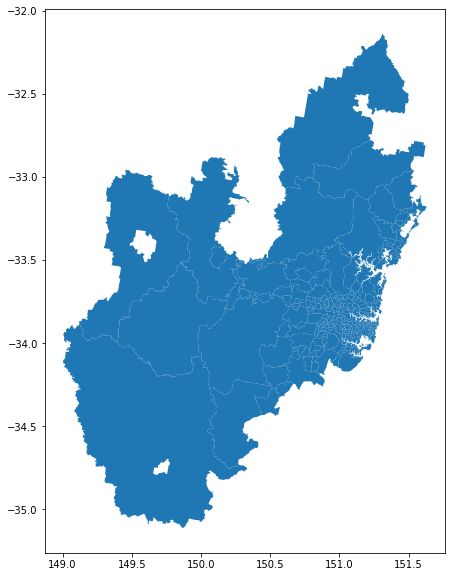

In [17]:
# Plot all neighborhoods
neighbourhoods_map.plot(figsize=(10,10))


In [25]:
# Data preprocessing
pgquery(conn, "UPDATE Neighbor SET population = replace(population, ',' , '')")


### (1) Health services

In [46]:
query = """SELECT N.area_name, N.land_area, N.population, B.health_care_and_social_assistance as hcnt,
			 CAST(B.health_care_and_social_assistance as NUMERIC)/(N.population::float/1000) AS "healthservice_density", N.geom
             FROM Neighbor N JOIN Business B ON N.area_id=B.area_id
             ORDER BY N.area_name ASC;
            """

healthservice_density = gpd.read_postgis(query, conn)
healthservice_density

,area_name,land_area,population,hcnt,healthservice_density,geom
0,Acacia Gardens,94.7,3905,13,3.329065,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,63,2.532867,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,41,2.287436,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,142,5.435407,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,75,3.925263,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."
...,...,...,...,...,...,...
317,Wyoming,838.1,11659,48,4.116991,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556..."
318,Wyong,1503.3,9114,30,3.291639,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042..."
319,Yagoona - Birrong,556.0,21834,70,3.206009,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769..."
320,Yarramundi - Londonderry,8143.6,7732,12,1.551992,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490..."


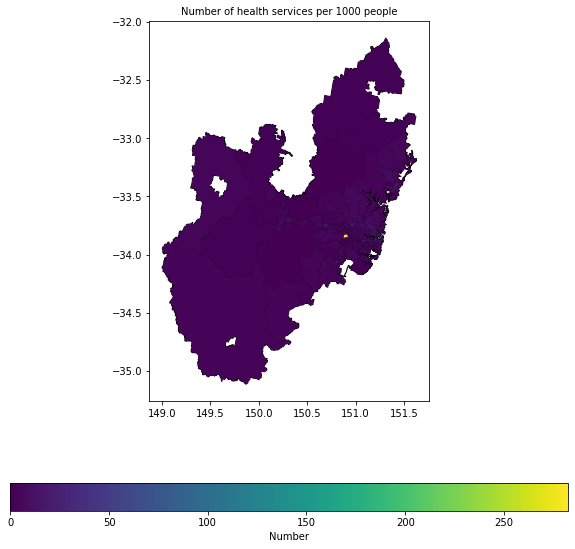

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Number of health services per 1000 people", fontsize=10.0)
legend_kwds = {'label': "Number", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
healthservice_density.plot(column="healthservice_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()


### (2) Retail services

In [52]:
query = """SELECT N.area_name, N.land_area, N.population, B.retail_trade as rcnt,
			 CAST(B.retail_trade as NUMERIC)/(N.population::float/1000) AS "retailservice_density", N.geom
             FROM Neighbor N JOIN Business B ON N.area_id=B.area_id
             ORDER BY N.area_name ASC;
            """

retailservice_density = gpd.read_postgis(query, conn)
print(retailservice_density.shape)
retailservice_density.head()


(322, 6)


,area_name,land_area,population,rcnt,retailservice_density,geom
0,Acacia Gardens,94.7,3905,27,6.914213,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,127,5.105938,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,25,1.394778,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,141,5.397129,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,76,3.977600,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."


In [48]:
retailservice_density['retailservice_density'].describe()

count     321.000000
mean       28.362415
std       165.456737
min         0.000000
25%         3.821169
50%         5.094614
75%         7.019783
max      1869.565217
Name: retailservice_density, dtype: float64

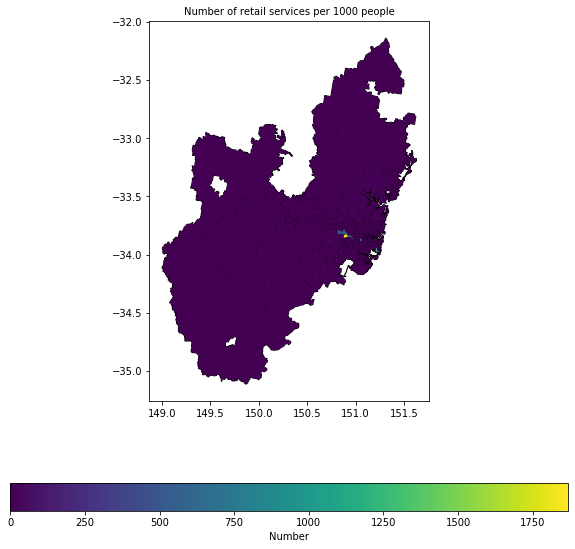

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Number of retail services per 1000 people", fontsize=10.0)
legend_kwds = {'label': "Number", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
retailservice_density.plot(column="retailservice_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### (3) Accommodation

In [53]:
query = """SELECT N.area_name, N.land_area, N.population, B.accommodation_and_food_services as acnt,
			 CAST(B.accommodation_and_food_services as NUMERIC)/(N.population::float/1000) AS "accomm_density", N.geom
             FROM Neighbor N JOIN Business B ON N.area_id=B.area_id
             ORDER BY N.area_name ASC;
            """

accomm_density = gpd.read_postgis(query, conn)
print(accomm_density.shape)
accomm_density.head()

(322, 6)


,area_name,land_area,population,acnt,accomm_density,geom
0,Acacia Gardens,94.7,3905,4,1.024328,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,89,3.578177,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,26,1.450569,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,112,4.287081,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,29,1.517768,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."


In [57]:
accomm_density['accomm_density'].describe()


count    321.000000
mean      10.719970
std       53.234305
min        0.000000
25%        2.095887
50%        3.226040
75%        4.867952
max      630.434783
Name: accomm_density, dtype: float64

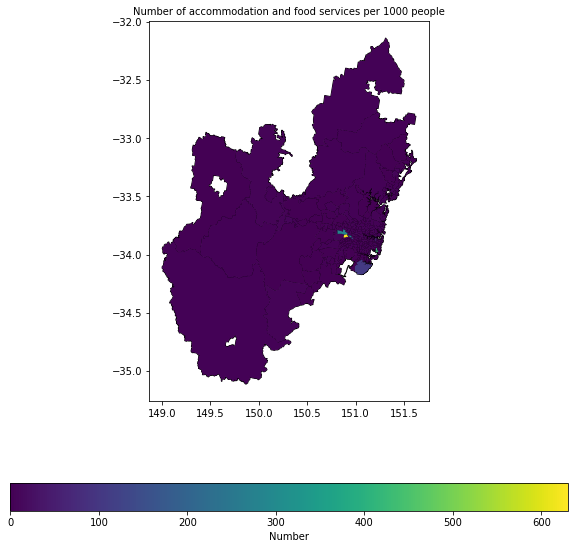

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Number of accommodation and food services per 1000 people", fontsize=10.0)
legend_kwds = {'label': "Number", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
accomm_density.plot(column="accomm_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### (4) Schools catchment

In [54]:
query = """SELECT N.area_name, N.land_area, N.population, count(S.use_id) AS number_schools, N.geom
             FROM Neighbor N LEFT JOIN School S ON (ST_Within(S.geom, N.geom))
             GROUP BY N.area_name, N.land_area, N.population, N.geom
             ORDER BY N.area_name ASC;
            """

school_density = gpd.read_postgis(query, conn)
print(school_density.shape)
school_density.head()

(322, 5)


,area_name,land_area,population,number_schools,geom
0,Acacia Gardens,94.7,3905,0,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,0,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,0,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,0,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,0,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."


In [57]:
school_density.describe()

,number_schools
count,322.000000
mean,0.127329
std,0.472876
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4.000000


In [58]:
# Count the density for young people
neighbour_data = pd.read_csv("Neighbourhoods.csv")
school_density['school_density'] = 0

for index, row in school_density.iterrows():
    area_name = row[0]
    tmp = neighbour_data[neighbour_data['area_name']==area_name]
    young_num = tmp['0-4'] + tmp['5-9'] + tmp['10-14'] + tmp['15-19']
    if int(young_num) > 0:
        school_density.iloc[[index], [5]] = int(row[3])*1000/(int(young_num))

school_density['school_density'].describe()


count    322.000000
mean       0.032988
std        0.158214
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.881468
Name: school_density, dtype: float64

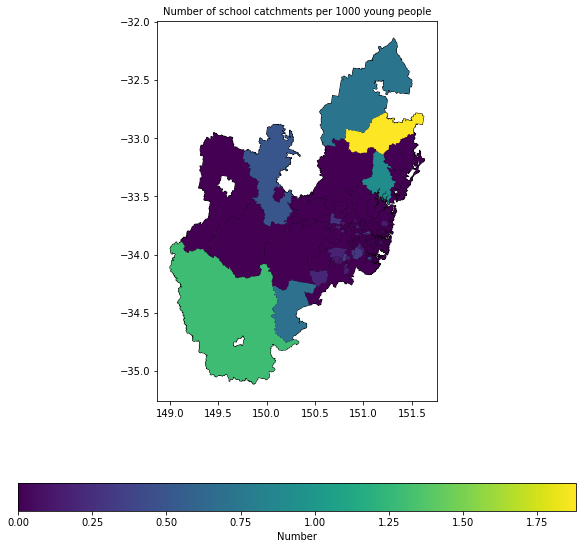

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Number of school catchments per 1000 young people", fontsize=10.0)
legend_kwds = {'label': "Number", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
school_density.plot(column="school_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### (5) Crime

In [55]:
query = """SELECT N.area_name, N.land_area, N.population, 
            sum(CAST(C.shape_area as NUMERIC))/(N.land_area::float) AS "hotspot_rate", N.geom
            FROM Neighbor N LEFT JOIN Crime C ON (ST_Within(C.geom, N.geom))
            GROUP BY N.area_name, N.land_area, N.population, N.geom
            ORDER BY N.area_name ASC;
            """

hotspot_rate = gpd.read_postgis(query, conn)
print(hotspot_rate.shape)
hotspot_rate.head()


(322, 5)


,area_name,land_area,population,hotspot_rate,geom
0,Acacia Gardens,94.7,3905,NaN,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,1.164089e-07,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,2.949548e-08,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,4.256425e-08,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,1.228709e-08,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."


In [103]:
hotspot_rate = hotspot_rate.fillna({"hotspot_rate":0})
hotspot_rate['hotspot_rate'].describe()

count    3.220000e+02
mean     4.703483e-08
std      9.830508e-08
min      0.000000e+00
25%      0.000000e+00
50%      1.462118e-08
75%      5.995289e-08
max      1.393253e-06
Name: hotspot_rate, dtype: float64

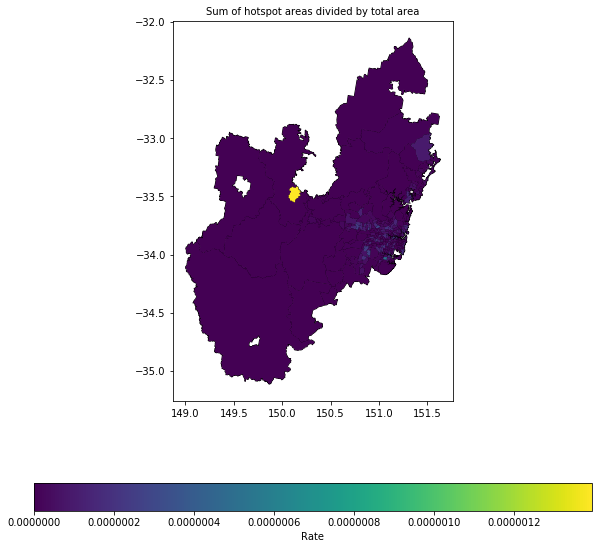

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Sum of hotspot areas divided by total area", fontsize=10.0)
legend_kwds = {'label': "Rate", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
hotspot_rate.plot(column="hotspot_rate", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

## Compute the ‘liveability’ score

In [59]:
# merge the dataframes to one
df_1 = pd.DataFrame(healthservice_density, columns = ['area_name', 'healthservice_density'])
df_2 = pd.DataFrame(retailservice_density, columns = ['area_name', 'retailservice_density'])
df_3 = pd.DataFrame(accomm_density, columns = ['area_name',  'accomm_density'])
df_4 = pd.DataFrame(school_density, columns = ['area_name', 'school_density'])
df_5 = pd.DataFrame(hotspot_rate, columns = ['area_name', 'hotspot_rate'])
df_6 = pd.DataFrame(neighbourhoods_map, columns = ['area_name', 'geom'])

df = pd.merge(df_1, df_2, on='area_name')
df = pd.merge(df, df_3, on='area_name')
df = pd.merge(df, df_4, on='area_name')
df = pd.merge(df, df_5, on='area_name')
df = pd.merge(df, df_6, on='area_name')

df

,area_name,healthservice_density,retailservice_density,accomm_density,school_density,hotspot_rate,geom
0,Acacia Gardens,3.329065,6.914213,1.024328,0.0,NaN,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,2.532867,5.105938,3.578177,0.0,1.164089e-07,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,2.287436,1.394778,1.450569,0.0,2.949548e-08,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,5.435407,5.397129,4.287081,0.0,4.256425e-08,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3.925263,3.977600,1.517768,0.0,1.228709e-08,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."
...,...,...,...,...,...,...,...
317,Wyoming,4.116991,2.830431,1.886954,0.0,5.793023e-08,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556..."
318,Wyong,3.291639,4.388852,7.790213,0.0,2.515381e-08,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042..."
319,Yagoona - Birrong,3.206009,4.763213,1.557204,0.0,3.073015e-09,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769..."
320,Yarramundi - Londonderry,1.551992,3.491981,1.551992,0.0,NaN,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490..."


We set z-score as:
$$z=\frac{x-\mu}{\sigma}$$
So that every column will be normalized according to its mean value and standard deviation.

In [145]:
mean_columns = df.mean(axis=0)
std_columns = df.std(axis=0, ddof=0)

def z_score(val, col):
    score = (val - mean_columns[col])/std_columns[col]
    if val is None or math.isnan(score):
        return 0
    return score

def sigmoid(x):
    return 1 / (1 + math.exp(-x))


liveability_column = []
attr_li = ['healthservice_density', 'retailservice_density', 'accomm_density', 'school_density', 'hotspot_rate']

for index, row in df.iterrows():  
    Z = 0
    for attr in attr_li:
        if attr == 'hotspot_rate':
            Z -= z_score(row[attr], attr)
        else:
            Z += z_score(row[attr], attr)
    liveability_column.append(sigmoid(Z))

df['liveability'] = liveability_column
df_geo = gpd.GeoDataFrame(df, geometry = 'geom')
df_geo

,area_name,healthservice_density,retailservice_density,accomm_density,school_density,hotspot_rate,geom,liveability
0,Acacia Gardens,3.329065,6.914213,1.024328,0.0,0.000000e+00,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661...",0.435939
1,Arncliffe - Bardwell Valley,2.532867,5.105938,3.578177,0.0,1.164089e-07,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304...",0.189106
2,Ashcroft - Busby - Miller,2.287436,1.394778,1.450569,0.0,2.949548e-08,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518...",0.343437
3,Ashfield,5.435407,5.397129,4.287081,0.0,4.256425e-08,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115...",0.375481
4,Asquith - Mount Colah,3.925263,3.977600,1.517768,0.0,1.228709e-08,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475...",0.412305
...,...,...,...,...,...,...,...,...
317,Wyoming,4.116991,2.830431,1.886954,0.0,5.793023e-08,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556...",0.308401
318,Wyong,3.291639,4.388852,7.790213,0.0,2.515381e-08,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042...",0.400294
319,Yagoona - Birrong,3.206009,4.763213,1.557204,0.0,3.073015e-09,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769...",0.425660
320,Yarramundi - Londonderry,1.551992,3.491981,1.551992,0.0,0.000000e+00,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490...",0.406510


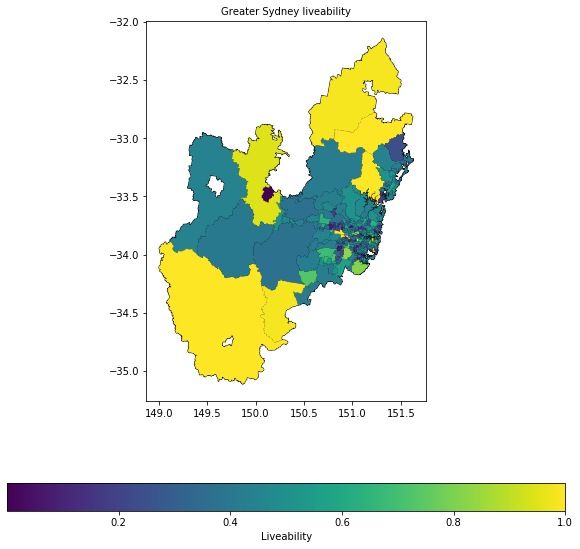

In [146]:
# Visualize the liveability
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Greater Sydney liveability", fontsize=10.0)
legend_kwds = {'label': "Liveability", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
df_geo.plot(column = 'liveability', figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Correlation
1. liveability score and median rent
2. liveability score and median income

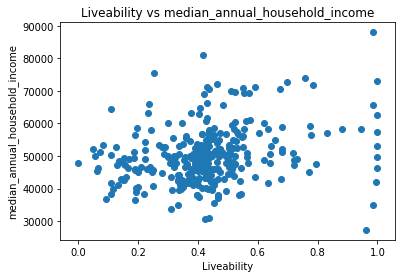

Pearson Correlation of median income and liveability:  0.2529963459258271


In [147]:
new_neighbour_df = pd.merge(neighbour_data, df, on='area_name')
live_df = new_neighbour_df['liveability']
income_df = new_neighbour_df['median_annual_household_income']
plt.scatter(live_df, income_df)
plt.xlabel("Liveability")
plt.ylabel("median_annual_household_income")
plt.title("Liveability vs median_annual_household_income")
plt.show()

d1=(live_df-np.mean(live_df))/np.std(live_df)
d2=(income_df-np.mean(income_df))/np.std(income_df)

def pearson(x, y, n):
    """
    warning: data format must be narray
    :param x: Variable 1
    :param y: The variable 2
    :param n: The number of elements in x
    :return: pccs
    """
    sum_xy = np.sum(np.sum(x*y))
    sum_x = np.sum(np.sum(x))
    sum_y = np.sum(np.sum(y))
    sum_x2 = np.sum(np.sum(x*x))
    sum_y2 = np.sum(np.sum(y*y))
    pcc = (n*sum_xy-sum_x*sum_y)/np.sqrt((n*sum_x2-sum_x*sum_x)*(n*sum_y2-sum_y*sum_y))
    return pcc

print("Pearson Correlation of median income and liveability: ", pearson(d1, d2, d1.shape[0]))

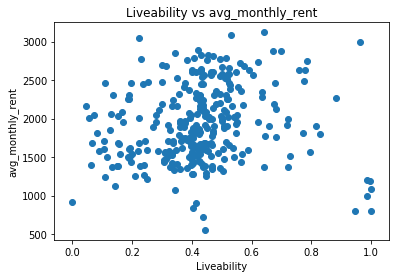

Pearson Correlation of median rent and liveability:  -0.1052540560141202


In [148]:
rent_df = new_neighbour_df['avg_monthly_rent']
plt.scatter(live_df, rent_df)
plt.xlabel("Liveability")
plt.ylabel("avg_monthly_rent")
plt.title("Liveability vs avg_monthly_rent")
plt.show()

print("Pearson Correlation of median rent and liveability: ", pearson(live_df, rent_df, live_df.shape[0]))

# Task 3 City of Sydney Analysis
Selected datasets: 
1. Greenhouse_gas_emissions_profile_by_suburb.geojson
2. Rain_gardens.geojson

The new liveability score is:
$$
\mathcal{S}\left(z_{accomm }+z_{retail}-z_{crime}+z_{health}+z_{garden}+z_{camera}\right)
$$

Where ${garden}$ means number of rain gardens per 1000 people, ${camera}$ means the street camera numbers per unit of area.

In [61]:
query = """SELECT N.area_name, N.land_area, N.population, count(*)/(N.land_area::float) as "camera_density", N.geom
            FROM Neighbor N LEFT JOIN camera C ON (ST_Within(C.geom, N.geom))
            GROUP BY N.area_name, N.land_area, N.population, N.geom
            ORDER BY N.area_name ASC;
            """

camera_density = gpd.read_postgis(query, conn)
camera_density

,area_name,land_area,population,camera_density,geom
0,Acacia Gardens,94.7,3905,0.010560,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,499.3,24873,0.002003,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,546.3,17924,0.001830,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,367.0,26125,0.002725,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,3468.5,19107,0.000288,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."
...,...,...,...,...,...
317,Wyoming,838.1,11659,0.001193,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556..."
318,Wyong,1503.3,9114,0.000665,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042..."
319,Yagoona - Birrong,556.0,21834,0.001799,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769..."
320,Yarramundi - Londonderry,8143.6,7732,0.000123,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490..."


In [62]:
garden_data = gpd.read_file("Rain_gardens.geojson").dropna()
garden_data

,FID,asset_id,Material,Catchment,No_Inlet,No_Outlet,Pit_Depth_mm,geometry
0,1,RG286,Small Pebbles,Blackwattle Bay,1.0,1.0,500.00,POINT (151.20017 -33.88613)
1,2,RG001,Small Pebbles,Rushcutters Bay,2.0,1.0,100.00,POINT (151.22105 -33.88090)
2,3,RG008,Not Applicable,Centennial Park,1.0,1.0,1100.00,POINT (151.22621 -33.88695)
3,4,RG009,Not Applicable,Centennial Park,1.0,1.0,1000.00,POINT (151.22632 -33.88698)
4,5,RG011,Bark Mulch,Sheas Creek,2.0,1.0,.00,POINT (151.21047 -33.88893)
...,...,...,...,...,...,...,...,...
244,245,RG270,Small Pebbles,Sheas Creek,1.0,1.0,.00,POINT (151.20482 -33.90658)
245,246,RG272,Small Pebbles,Sheas Creek,1.0,1.0,1200.00,POINT (151.20426 -33.90592)
246,247,RG273,Small Pebbles,Sheas Creek,1.0,1.0,.00,POINT (151.20423 -33.90587)
247,248,RG275,Small Pebbles,Sheas Creek,1.0,1.0,.00,POINT (151.20409 -33.90592)


In [45]:
query = """SELECT N.area_name, N.population, count(*)/(N.population::float/1000) as "garden_density", N.geom
            FROM Neighbor N LEFT JOIN garden G ON (ST_Within(G.geom, N.geom))
            GROUP BY N.area_name, N.land_area, N.population, N.geom
            ORDER BY N.area_name ASC;
            """

garden_density = gpd.read_postgis(query, conn)
garden_density

,area_name,population,garden_density,geom
0,Acacia Gardens,3905,0.256082,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661..."
1,Arncliffe - Bardwell Valley,24873,0.040204,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
2,Ashcroft - Busby - Miller,17924,0.055791,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
3,Ashfield,26125,0.038278,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
4,Asquith - Mount Colah,19107,0.052337,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."
...,...,...,...,...
317,Wyoming,11659,0.085771,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556..."
318,Wyong,9114,0.109721,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042..."
319,Yagoona - Birrong,21834,0.045800,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769..."
320,Yarramundi - Londonderry,7732,0.129333,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490..."


In [64]:
df_a = pd.DataFrame(camera_density, columns = ['area_name', 'camera_density'])
df_b = pd.DataFrame(garden_density, columns = ['area_name', 'garden_density'])

new_df = pd.merge(df, df_a, on='area_name')
new_df = pd.merge(new_df, df_b, on='area_name')

new_df


,area_name,healthservice_density,retailservice_density,accomm_density,school_density,hotspot_rate,geom,camera_density,garden_density
0,Acacia Gardens,3.329065,6.914213,1.024328,0.0,NaN,"MULTIPOLYGON (((150.91593 -33.72972, 150.91661...",0.010560,0.256082
1,Arncliffe - Bardwell Valley,2.532867,5.105938,3.578177,0.0,1.164089e-07,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304...",0.002003,0.040204
2,Ashcroft - Busby - Miller,2.287436,1.394778,1.450569,0.0,2.949548e-08,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518...",0.001830,0.055791
3,Ashfield,5.435407,5.397129,4.287081,0.0,4.256425e-08,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115...",0.002725,0.038278
4,Asquith - Mount Colah,3.925263,3.977600,1.517768,0.0,1.228709e-08,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475...",0.000288,0.052337
...,...,...,...,...,...,...,...,...,...
317,Wyoming,4.116991,2.830431,1.886954,0.0,5.793023e-08,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556...",0.001193,0.085771
318,Wyong,3.291639,4.388852,7.790213,0.0,2.515381e-08,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042...",0.000665,0.109721
319,Yagoona - Birrong,3.206009,4.763213,1.557204,0.0,3.073015e-09,"MULTIPOLYGON (((151.00731 -33.90153, 151.00769...",0.001799,0.045800
320,Yarramundi - Londonderry,1.551992,3.491981,1.551992,0.0,NaN,"MULTIPOLYGON (((150.64355 -33.63580, 150.64490...",0.000123,0.129333


In [66]:
mean_columns = new_df.mean(axis=0)
std_columns = new_df.std(axis=0, ddof=0)

def z_score(val, col):
    score = (val - mean_columns[col])/std_columns[col]
    if val is None or math.isnan(score):
        return 0
    return score

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

liveability_column = []
attr_li = ['healthservice_density', 'retailservice_density', 'accomm_density', 'hotspot_rate', 'garden_density', 'camera_density']

for index, row in new_df.iterrows():  
    Z = 0
    for attr in attr_li:
        if attr == 'hotspot_rate':
            Z -= z_score(row[attr], attr)
        else:
            Z += z_score(row[attr], attr)
    liveability_column.append(sigmoid(Z))

new_df['new_liveability'] = liveability_column

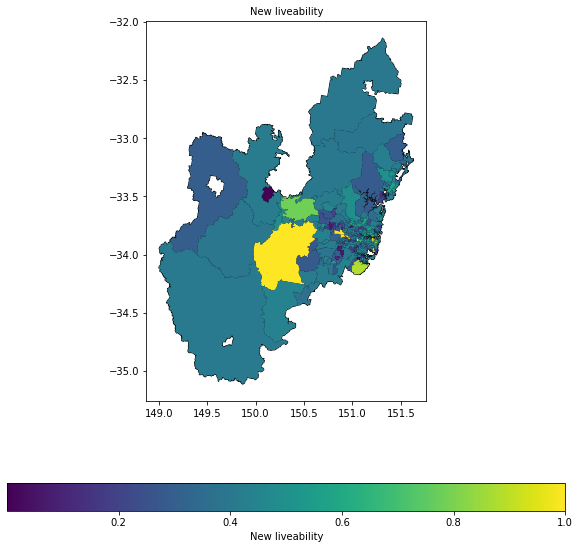

In [67]:
# Visualize the new liveability
df_new_geo = gpd.GeoDataFrame(new_df, geometry = 'geom')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("New liveability", fontsize=10.0)
legend_kwds = {'label': "New liveability", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
df_new_geo.plot(column = 'new_liveability', figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

In [69]:
# Sort by the new liveability
new_df.sort_values(by='new_liveability', ascending=False)

,area_name,healthservice_density,retailservice_density,accomm_density,school_density,hotspot_rate,geom,camera_density,garden_density,new_liveability
308,Wetherill Park Industrial,282.608696,1869.565217,630.434783,0.000000,NaN,"MULTIPOLYGON (((150.87999 -33.84014, 150.88005...",0.001169,21.739130,1.000000
237,Port Botany Industrial,0.000000,1285.714286,428.571429,0.000000,NaN,"MULTIPOLYGON (((151.22090 -33.96897, 151.22066...",0.003566,142.857143,1.000000
14,Banksmeadow,0.000000,1238.095238,428.571429,0.000000,NaN,"MULTIPOLYGON (((151.20806 -33.95406, 151.20816...",0.002969,47.619048,1.000000
255,Rookwood Cemetery,0.000000,1000.000000,0.000000,0.000000,NaN,"MULTIPOLYGON (((151.05662 -33.86477, 151.05662...",0.003317,333.333333,1.000000
284,Sydney - Haymarket - The Rocks,39.245405,54.853273,54.337311,0.000000,NaN,"MULTIPOLYGON (((151.22538 -33.85527, 151.22524...",0.165386,0.193486,1.000000
...,...,...,...,...,...,...,...,...,...,...
276,St Marys - North St Marys,3.512741,6.311026,2.738747,0.000000,2.441119e-07,"MULTIPOLYGON (((150.76733 -33.73565, 150.76777...",0.000777,0.059538,0.079796
21,Baulkham Hills (East),5.621666,4.513746,2.749282,0.000000,2.848908e-07,"MULTIPOLYGON (((150.97069 -33.75928, 150.97071...",0.001204,0.041034,0.065096
184,Macquarie Fields - Glenfield,2.076885,2.524841,1.343867,0.283366,2.607628e-07,"MULTIPOLYGON (((150.87958 -33.96362, 150.88060...",0.000624,0.040723,0.060242
281,Sutherland - Kirrawee,5.836397,5.193015,3.354779,0.408664,4.827882e-07,"MULTIPOLYGON (((151.05049 -34.02006, 151.05098...",0.001289,0.045956,0.011748
